# A Data Science Analysis of Where to Open a Traditional Irish Pub in Austin Texas

## Introduction/Business Problem

The city of Austin, Texas, is one of the fastest-growing cities in the United States in the number of people moving there each year.  In 2018, the population of Austin grew by 2.5%, with an estimated 100 people moving to the Austin metro area each day .  It is home to the University of Texas and a growing technology industry.  It is also growing in affluence, median income increased 9.35% over the past three years compared to the national average of 5.60%. Putting these factors together, Austin seems to offer a fertile opportunity for new business.

Even before Austin became a "go-to destination" for relocation, it was well known for its nightlife and its live music scene earning it the nickname of "Live Music Capital of the World."  Surprisingly, a preliminary examination of venues in Austin shows a lack of traditional Irish Pubs, defined as a place that combines not only the service of food and drink and traditional Irish Music, not just a place that serves Guinness.   Given that Irish Music has influenced many of the music genres that Austin is noted for, a traditional Irish pub could strike a balance in being both something different and yet familiar with broad appeal.

The question, of course, is where is the ideal location to put open such a business and using data science analysis, this project attempts to answer this question


## Data Overview

To identify an appropriate location, we need to establish our criterion and locate data to support the same.  After a survey, the following criteria and data sources were identified
<ul>
<li>Austin Texas neighborhoods as identified by ZIP code.  Here we use data provided by SimpleMaps (<a href='https://simplemaps.com/data/us-zips'>https://simplemaps.com/data/us-zips)</a>.  The free version provides data on US zip codes, including Latitudes and Longitudes (thus eliminating the need for GeoEncoding) and population density.</li>
<li>Data on existing venues, and potential competitors, from the FourSquare api.  Data to be accessed including venues in the areas and ratings. (<a href='https://foursquare.com/'>https://foursquare.com/</a>)</li>
<li>Median Income Data from the (<a href='http://zipatlas.com/us/tx/austin/zip-code-comparison/median-household-income.htm'>http://zipatlas.com/us/tx/austin/zip-code-comparison/median-household-income.htm</a>)
<li>Existing sales of Beer, Wine and Mixed drinks as reported by the Texas Department of Taxation  (<a href='https://data.texas.gov/Government-and-Taxes/Mixed-Beverage-Gross-Receipts/naix-2893/data'>https://data.texas.gov/Government-and-Taxes/Mixed-Beverage-Gross-Receipts/naix-2893/data</a>)</li>
<li>Crime Data from the Texas Department of Public Safety.  For the purposed of this study, we will only look at "serious crime" as determined by the assignment of an FBI tracking number. (<a href='https://data.austintexas.gov/Public-Safety/Crime-Reports-2018/vmn9-3bvu'>https://data.austintexas.gov/Public-Safety/Crime-Reports-2018/vmn9-3bvu</a>)</li>
</ul>

## Preliminaries, Import required libraries

We import the libraries that we will use as part of this project

In [1]:
import pandas as pd
import numpy as np # linear algebra
import censusdata
import json
import re
import requests
from bs4 import BeautifulSoup
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from sklearn import preprocessing

## Data Aquisition and Cleaning

### Identify Austin Neighborhoods

We obtain our Austin neighborhood data.  Perhaps as a byproduct of the city’s rapid growth, there appears to be no fixed agreement on neighborhood names.  Rather than inadvertently exclude data, we will use Zip Codes themselves as the definition of a neighborhood.

I was fortunate to find a dataset from SimpleMaps that already provided Austin, Texas zip codes, their latitudes and longitudes and the population density which will be used in later analysis.


In [2]:
dZip=pd.read_csv('./Capstone/uszips.csv')
dZip.head()

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,601,18.18004,-66.75218,Adjuntas,PR,Puerto Rico,True,NaN,17242,111.4,72001,Adjuntas,"{'72001':99.43,'72141':0.57}",Adjuntas|Utuado,72001|72141,False,False,America/Puerto_Rico
1,602,18.36073,-67.17517,Aguada,PR,Puerto Rico,True,NaN,38442,523.5,72003,Aguada,{'72003':100},Aguada,72003,False,False,America/Puerto_Rico
2,603,18.45439,-67.12202,Aguadilla,PR,Puerto Rico,True,NaN,48814,667.9,72005,Aguadilla,{'72005':100},Aguadilla,72005,False,False,America/Puerto_Rico
3,606,18.16724,-66.93828,Maricao,PR,Puerto Rico,True,NaN,6437,60.4,72093,Maricao,"{'72093':94.88,'72121':1.35,'72153':3.78}",Maricao|Yauco|Sabana Grande,72093|72153|72121,False,False,America/Puerto_Rico
4,610,18.29032,-67.12243,Anasco,PR,Puerto Rico,True,NaN,27073,312.0,72011,Añasco,"{'72003':0.55,'72011':99.45}",Añasco|Aguada,72011|72003,False,False,America/Puerto_Rico


We obtain our Austin neighborhood data.  Perhaps as a byproduct of the city’s rapid growth, there appears to be no fixed agreement on neighborhood names.  Rather than inadvertently exclude data, we will use Zip Codes themselves as the definition of a neighborhood.

I was fortunate to find a dataset from SimpleMaps that already provided Austin, Texas zip codes, their latitudes and longitudes and the population density which will be used in later analysis.

We cull down the data to just Austin, Texas Zips and drop some extraneous columns we will not use.  We implement a convention that we will use through the analysis that our header titles will capitalize each significant word, and that Zip Code will be treated as a string rather than a number.


In [3]:
#Limit data to Austin, TX
 
dZip = dZip[(dZip['state_id'] == 'TX') & (dZip['city'] == 'Austin')]
print("Shape of frame ",dZip.shape)
dZip.head()

Shape of frame  (44, 18)


,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
27356,78701,30.27049,-97.74235,Austin,TX,Texas,True,NaN,9427,1621.8,48453,Travis,{'48453':100},Travis,48453,False,False,America/Chicago
27357,78702,30.26327,-97.71432,Austin,TX,Texas,True,NaN,23389,1648.1,48453,Travis,{'48453':100},Travis,48453,False,False,America/Chicago
27358,78703,30.29409,-97.76571,Austin,TX,Texas,True,NaN,20890,1366.4,48453,Travis,{'48453':100},Travis,48453,False,False,America/Chicago
27359,78704,30.24315,-97.76537,Austin,TX,Texas,True,NaN,48486,1871.5,48453,Travis,{'48453':100},Travis,48453,False,False,America/Chicago
27360,78705,30.29437,-97.73855,Austin,TX,Texas,True,NaN,33948,5511.2,48453,Travis,{'48453':100},Travis,48453,False,False,America/Chicago


In [4]:
dZip.dtypes

zip                   int64
lat                 float64
lng                 float64
city                 object
state_id             object
state_name           object
zcta                   bool
parent_zcta         float64
population            int64
density             float64
county_fips           int64
county_name          object
county_weights       object
county_names_all     object
county_fips_all      object
imprecise              bool
military               bool
timezone             object
dtype: object

In [5]:
dZip["zip"]=dZip["zip"].astype(str)

In [6]:
#Let us get rid of some of the clutter
dZip.drop(['zcta', 'parent_zcta','county_fips','county_fips_all','county_name','county_weights','county_names_all','imprecise','military','timezone'],axis=1, inplace=True)
dZip.reset_index(drop=True,inplace=True) 
#Rename the "zip" column to avoid confusion with the "zip" command, make column title case as a standard 
dZip.rename(columns = {'zip':'Zip Code','lat':'Lat','lng':'Lng','city':'City','state_id':'State ID','state_name':'State Name','population':'Population','density':'Density'}, inplace = True)

At the end of the process, we have a DataFrame <b>dZip</b> with our basic neighborhood data

In [7]:
dZip.head()

,Zip Code,Lat,Lng,City,State ID,State Name,Population,Density
0,78701,30.27049,-97.74235,Austin,TX,Texas,9427,1621.8
1,78702,30.26327,-97.71432,Austin,TX,Texas,23389,1648.1
2,78703,30.29409,-97.76571,Austin,TX,Texas,20890,1366.4
3,78704,30.24315,-97.76537,Austin,TX,Texas,48486,1871.5
4,78705,30.29437,-97.73855,Austin,TX,Texas,33948,5511.2


### What Our Neighbordhoods Look like

To make sure we are off to a good start, we plotr our neighborhoods, the result is below.

In [8]:
address = "Austin, TX"

geolocator = Nominatim(user_agent="austin_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
mapNeighborhoods = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, neighborhood in zip(
        dZip['Lat'], 
        dZip['Lng'], 
        dZip['Zip Code']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapNeighborhoods)  

mapNeighborhoods

78712 is a special Zip Code for the University of Texas.  It is an edge case in many, many ways: as students they are disproportionately young, their income is misleadingly low as they are often full time students, many venues are not publicly accessible, etc.  So, despite likely being a great source of customers for our prospective Pub owner 😊 , we remove them from the analysis so as not to inadvertently skew the analysis.  

In [9]:
dZip = dZip[dZip["Zip Code"] != '78712']
dZip.shape

(43, 8)

### Get Financial Data

It is obviously in the best interest of the business to be in an area where customers have disposable income.  We screenscrape the Average Household income for each Austin zip code.  Creating a DataFrame <b>dIncome</b>, changing the currency string to a floating point number by way of a regular expression

In [10]:
x=pd.read_html("http://zipatlas.com/us/tx/austin/zip-code-comparison/median-household-income.htm")
dIncome=x[11]
dIncome.head()

,0,1,2,3,4,5,6
0,#,Zip Code,Location,City,Population,Avg. Income/H/hold,National Rank
1,1.,78730,"30.363632, -97.850355","Austin, Texas",4885,"$128,524.00",#58
2,2.,78732,"30.382536, -97.894904","Austin, Texas",3629,"$103,951.00",#209
3,3.,78739,"30.178839, -97.889064","Austin, Texas",8643,"$102,707.00",#227
4,20.,78748,"30.159688, -97.823287","Austin, Texas",25361,"$57,710.00","#3,441"


In [11]:
#Lets get rid of redundant columens
dIncome.drop([0,2,3,4,6],axis=1, inplace=True)

In [12]:
new_header = dIncome.iloc[0] #grab the first row for the header
dIncome.drop(dIncome.index[0],inplace=True)
dIncome.columns = new_header
dIncome.head()

,Zip Code,Avg. Income/H/hold
1,78730,"$128,524.00"
2,78732,"$103,951.00"
3,78739,"$102,707.00"
4,78748,"$57,710.00"
5,78719,"$36,480.00"


In [13]:
dIncome['Avg. Income/H/hold']=dIncome['Avg. Income/H/hold'].replace('[\$,]', '', regex=True).astype(float)
dIncome.head()
print (dIncome.shape)
dIncome.head()

(43, 2)


,Zip Code,Avg. Income/H/hold
1,78730,128524.0
2,78732,103951.0
3,78739,102707.0
4,78748,57710.0
5,78719,36480.0


We do a quit plot of our income data as a quick visualization.  We note that there is a great deal of disparity between the income levels of Austin zips codes, roughly a $100k swing in yearly household income.  THis is certainly something to be cognizant of in choosing a location for our Pub business.

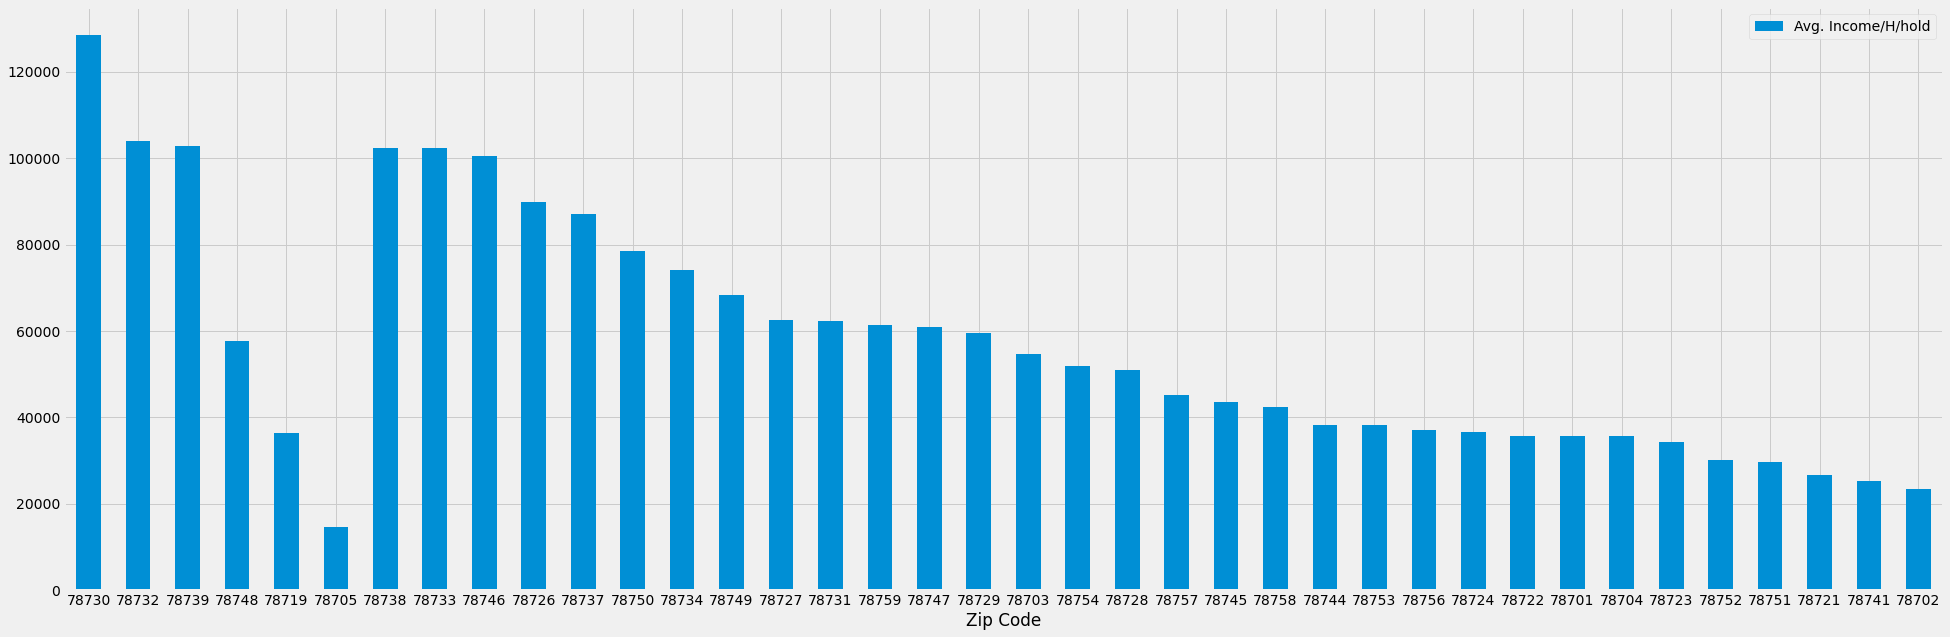

In [79]:
ax = dIncome.plot.bar(x='Zip Code', y='Avg. Income/H/hold', rot=0,figsize=(30,10),sort_columns=True)

### Get Demographic Data

#### Median Age

The median age of the neighborhood is an important consideration.  While certainly welcoming anyone pf a legal drinking age, it is certainly true that younger adults who have more free time and disposable income and may be active in the dating scene are an important demographic for a Pub.  We create a DataFrame, again through screen-scrapping,to get the average age for the residents of each zip code.  We will call this DataFrame <b>dAge</b>.  Again, we will do a plot as a first order sanity check.

In [15]:
x=pd.read_html("http://zipatlas.com/us/tx/austin/zip-code-comparison/median-age.htm")
dAge=x[11]
print(dAge.shape)
dAge.head()

(44, 7)


,0,1,2,3,4,5,6
0,#,Zip Code,Location,City,Population,Avg. Population Age,National Rank
1,1.,78738,"30.327510, -97.989040","Austin, Texas",2840,44.7,"#2,611"
2,2.,78734,"30.376159, -97.946334","Austin, Texas",12925,40.6,"#7,893"
3,3.,78747,"30.122470, -97.746210","Austin, Texas",5079,40.2,"#8,682"
4,4.,78737,"30.177041, -97.956661","Austin, Texas",7100,40.0,"#9,356"


In [16]:
new_header = dAge.iloc[0] #grab the first row for the header
dAge.drop(dAge.index[0],inplace=True)
dAge.columns = new_header
dAge.reset_index(drop=True,inplace=True) 
dAge.head()
print (dIncome.shape)
dAge.head()

(43, 2)


,#,Zip Code,Location,City,Population,Avg. Population Age,National Rank
0,1.,78738,"30.327510, -97.989040","Austin, Texas",2840,44.7,"#2,611"
1,2.,78734,"30.376159, -97.946334","Austin, Texas",12925,40.6,"#7,893"
2,3.,78747,"30.122470, -97.746210","Austin, Texas",5079,40.2,"#8,682"
3,4.,78737,"30.177041, -97.956661","Austin, Texas",7100,40.0,"#9,356"
4,5.,78746,"30.296951, -97.811647","Austin, Texas",26023,38.3,"#14,001"


In [17]:
#Let us check our types
dAge.dtypes

0
#                      object
Zip Code               object
Location               object
City                   object
Population             object
Avg. Population Age    object
National Rank          object
dtype: object

In [18]:
dAge['Avg. Population Age'] = dAge['Avg. Population Age'].astype(float)

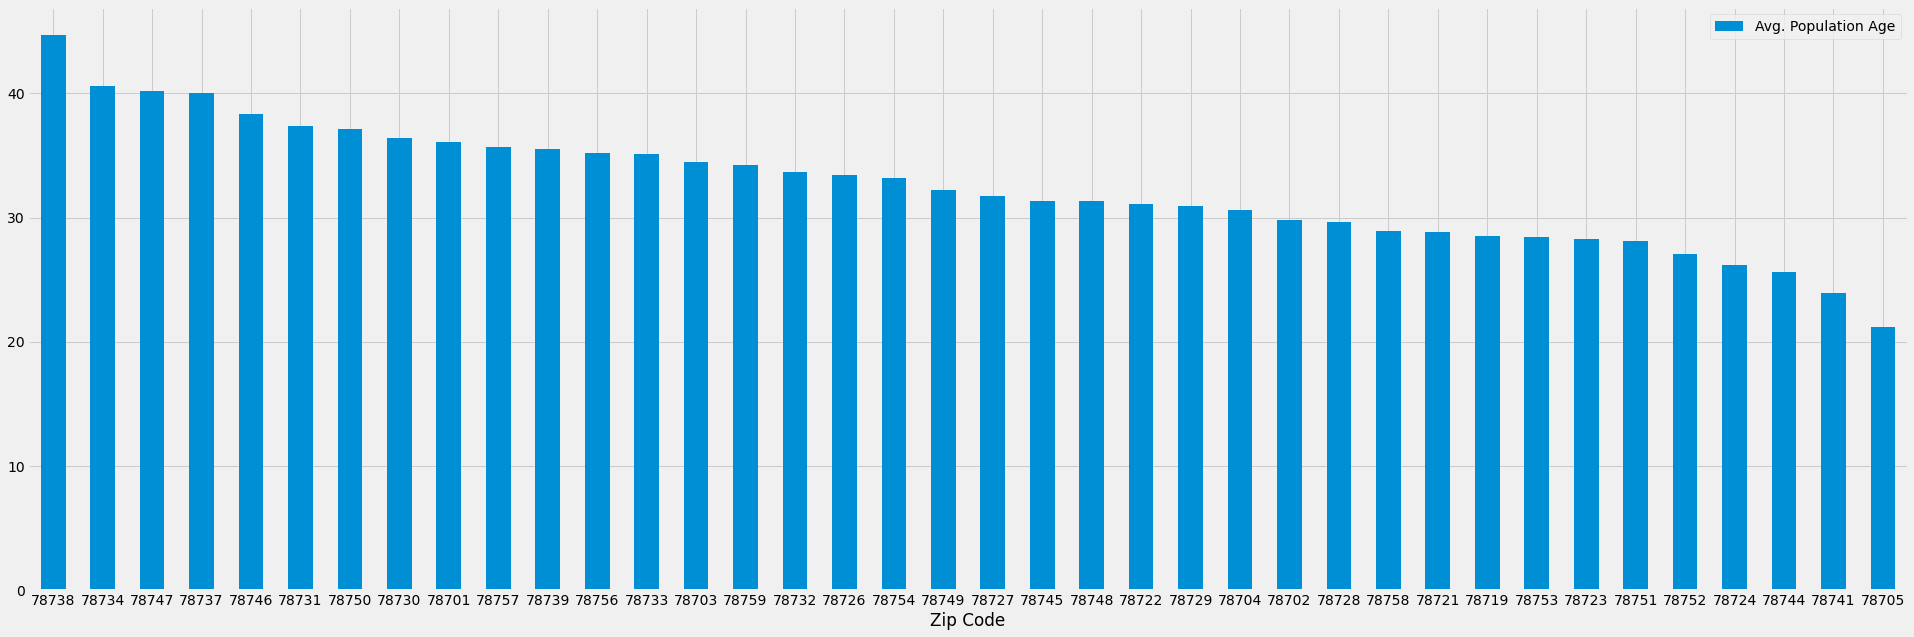

In [80]:
ax = dAge.plot.bar(x='Zip Code', y='Avg. Population Age', rot=0,figsize=(30,10),sort_columns=True)

Well good news for our prospective Pub Owners, we see that Austin is a very young city.

### Alcohol Sales

We look at the neighborhoods to see where the volume of existing Alcohol sales. The interpretation of this has to be balanced, as on the plus side it indicates a marker on the negative a lot of sales also implies a lost of competition. We will create a DataFrame <B>dAlcSales</B>  where we calculate the total receipts foe Alcohol and Cover Charges.  Again, we will do a visualization as a first order sanity.

In [20]:
dAlcSales=pd.read_csv('C:/Users/ncosgrov/Capstone/Mixed_Beverage_Gross_Receipts.csv')
#We know from the Release Notes that this is a wide data set, Lets get the Column Names and types
dAlcSales.dtypes

Taxpayer Number                 int64
Taxpayer Name                  object
Taxpayer Address               object
Taxpayer City                  object
Taxpayer State                 object
Taxpayer Zip                  float64
Taxpayer County                 int64
Location Number                 int64
Location Name                  object
Location Address               object
Location City                  object
Location State                 object
Location Zip                    int64
Location County                 int64
Inside/Outside City Limits     object
TABC Permit Number             object
Responsibility Begin Date      object
Responsibility End Date        object
Obligation End Date            object
Liquor Receipts                 int64
Wine Receipts                   int64
Beer Receipts                   int64
Cover Charge Receipts           int64
Total Receipts                  int64
dtype: object

In [21]:
#Ok, Let us pare it down to what we need
dAlcSales = dAlcSales[['Location Zip', 'Liquor Receipts','Wine Receipts','Beer Receipts','Cover Charge Receipts','Total Receipts']]
dAlcSales.head()

,Location Zip,Liquor Receipts,Wine Receipts,Beer Receipts,Cover Charge Receipts,Total Receipts
0,75201,2201,762,1663,0,4626
1,78526,20070,14995,5095,0,40160
2,78669,12402,1744,16634,0,30780
3,79424,28153,359,29588,0,58100
4,77380,30460,11448,9555,0,51463


In [22]:
# Let us clean up data types and column names
dAlcSales["Location Zip"]=dAlcSales["Location Zip"].astype(str)
dAlcSales.rename(columns = {'Location Zip':'Zip Code'}, inplace = True) 

In [23]:
#Let's reduse the frame to just Austin

dAlcSales=dAlcSales[(dAlcSales['Zip Code'].isin(dZip['Zip Code']))]
dAlcSales.head()

,Zip Code,Liquor Receipts,Wine Receipts,Beer Receipts,Cover Charge Receipts,Total Receipts
13,78701,61292,154774,13516,0,229582
19,78748,16932,843,3232,0,21007
20,78705,134921,1860,25999,0,162780
32,78704,11687,403,3186,0,15276
50,78701,34517,444,41960,0,76921


In [24]:
#Let's see what we have

dAlcSales = dAlcSales.groupby('Zip Code').sum().reset_index()
print(dAlcSales.shape)
dAlcSales.head()

(42, 6)


,Zip Code,Liquor Receipts,Wine Receipts,Beer Receipts,Cover Charge Receipts,Total Receipts
0,78701,1730557234,471027184,726031548,9900531,2938494875
1,78702,189717985,40870311,98634074,26786,331019849
2,78703,109644280,59177126,55465800,286,224481722
3,78704,493792962,146352596,286754273,1385306,929197089
4,78705,74841248,18511078,54069614,978557,148663399


In [25]:
#Someone is missing; who is not drinking?

print(dZip[(~dZip['Zip Code'].isin(dAlcSales['Zip Code']))])

   Zip Code       Lat       Lng    City State ID State Name  Population  \
12    78725  30.23581 -97.60837  Austin       TX      Texas        7886   

    Density  
12    133.1  


In [26]:
#Seems a low Density area with likely few venues to generat sales. insert row for region with no sales
new_row = {'Zip Code':'78725','Liquor Receipts':0,'Wine Receipts':0,'Beer Receipts':0,'Cover Charge Receipts':0,'Total Receipts':0}
dAlcSales = dAlcSales.append(new_row, ignore_index=True)
print(dAlcSales.shape)
dAlcSales.head()

(43, 6)


,Zip Code,Liquor Receipts,Wine Receipts,Beer Receipts,Cover Charge Receipts,Total Receipts
0,78701,1730557234,471027184,726031548,9900531,2938494875
1,78702,189717985,40870311,98634074,26786,331019849
2,78703,109644280,59177126,55465800,286,224481722
3,78704,493792962,146352596,286754273,1385306,929197089
4,78705,74841248,18511078,54069614,978557,148663399


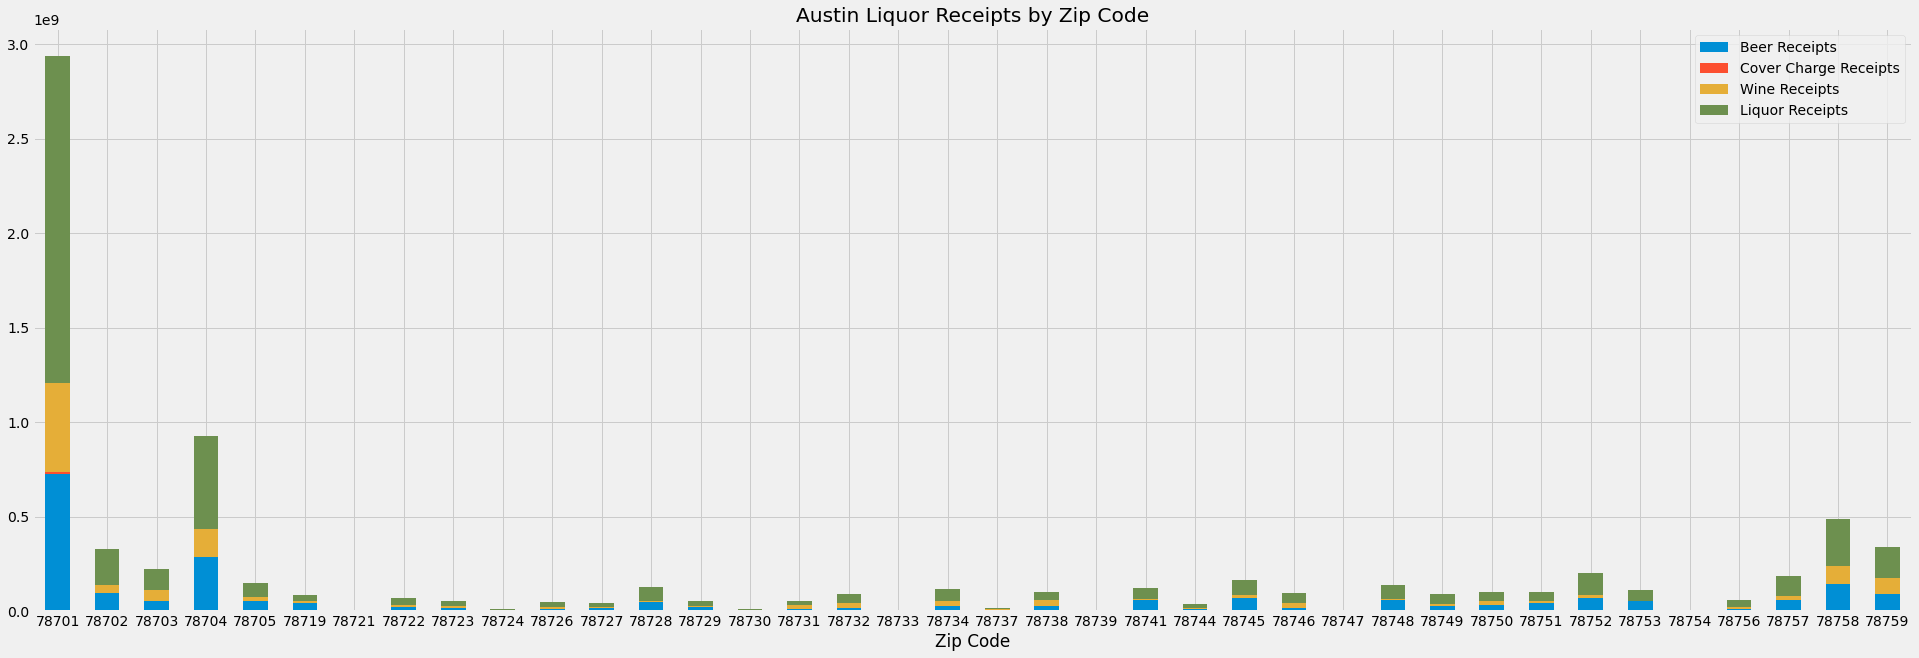

In [81]:

ax = dAlcSales.plot.bar(x='Zip Code', y={'Beer Receipts','Liquor Receipts','Wine Receipts','Cover Charge Receipts'}, rot=0,figsize=(30,10),stacked=True,title="Austin Liquor Receipts by Zip Code",sort_columns=True)


Note: I would suspect that the large amount of liquor receipts is a reflection of pricing, not consumption! Also I leave it to the reader to infer what they may that 78701 is the location of the Texas capital building!

### Get Crime Data

In setting up a "night life" venue like a pub, people need to have a sense of security.  Let us look at the crime data of the neighborhoods, but limit our search to "serious crime" (not an expired meter or littering) as tracked by the FBI and is assigned a UCR ("Uniform Crime Reporting ") number.  From this we will create a DataFrame <b>dCrime</b>

In [28]:
dCrime=pd.read_csv('./Capstone/Crime_Reports_2018.csv')
dCrime.head()

,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,...,Census Tract,Clearance Status,Clearance Date,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
0,2.018500e+10,BURGLARY OF VEHICLE,601,N,12/31/2017 22:00,12/31/2017,2200,1/1/2018 10:55,1/1/2018,1055,...,NaN,N,1/4/2018,23F,Theft,3117968.0,3117968.0,30.241810,-97.731933,"(30.24180963, -97.73193316)"
1,2.018102e+08,FELONY ENHANCEMENT/ASSLT W/INJ,909,Y,1/1/2018 1:01,1/1/2018,101,1/1/2018 1:01,1/1/2018,101,...,NaN,C,1/1/2018,NaN,NaN,3110156.0,3110156.0,30.186692,-97.758149,"(30.18669219, -97.75814874)"
2,2.018104e+08,ASSAULT ON PUBLIC SERVANT,903,N,1/1/2018 3:29,1/1/2018,329,1/1/2018 3:29,1/1/2018,329,...,NaN,C,1/13/2018,NaN,NaN,3114956.0,3114956.0,30.267224,-97.740792,"(30.26722355, -97.74079189)"
3,2.018101e+08,PUBLIC INTOXICATION,2300,N,1/1/2018 0:22,1/1/2018,22,1/1/2018 0:22,1/1/2018,22,...,NaN,C,1/1/2018,NaN,NaN,3115180.0,3115180.0,30.267613,-97.740072,"(30.26761327, -97.74007168)"
4,2.018104e+08,DISTURBANCE - OTHER,3401,N,1/1/2018 1:45,1/1/2018,145,1/1/2018 1:45,1/1/2018,145,...,NaN,NaN,NaN,NaN,NaN,3115180.0,3115180.0,30.267613,-97.740072,"(30.26761327, -97.74007168)"


Another "wide dataset".  Let us kill two birds by getting a listing on columns and types 

In [29]:
dCrime.dtypes 

Incident Number                float64
Highest Offense Description     object
Highest Offense Code             int64
Family Violence                 object
Occurred Date Time              object
Occurred Date                   object
Occurred Time                    int64
Report Date Time                object
Report Date                     object
Report Time                      int64
Location Type                   object
Address                         object
Zip Code                       float64
Council District               float64
APD Sector                      object
APD District                    object
PRA                            float64
Census Tract                   float64
Clearance Status                object
Clearance Date                  object
UCR Category                    object
Category Description            object
X-coordinate                   float64
Y-coordinate                   float64
Latitude                       float64
Longitude                

In [30]:
dCrime["Zip Code"]=dCrime["Zip Code"].astype(str)
dCrime = dCrime[['Zip Code','UCR Category']]
dCrime.head()

,Zip Code,UCR Category
0,78741.0,23F
1,78744.0,NaN
2,78701.0,NaN
3,78701.0,NaN
4,78701.0,NaN


In [31]:
dCrime["Zip Code"]=dCrime["Zip Code"].str[0:5]
dCrime=dCrime[(dCrime['Zip Code'].isin(dZip['Zip Code']))]

In [32]:
dCrime.head()

,Zip Code,UCR Category
0,78741,23F
1,78744,NaN
2,78701,NaN
3,78701,NaN
4,78701,NaN


In [33]:
#Let us drop any record that doesn't represent  a serious crime 
dCrime = dCrime[dCrime['UCR Category'].notna()]
dCrime.head()

,Zip Code,UCR Category
0,78741,23F
5,78752,23H
6,78745,240
8,78701,13A
17,78741,23H


In [34]:
dCrime = dCrime.groupby('Zip Code').count().reset_index()
dCrime.rename(columns = {'UCR Category':'UCR Crime Count'}, inplace = True) 

In [35]:
print(dCrime.shape)
dCrime.head()

(42, 2)


,Zip Code,UCR Crime Count
0,78701,2119
1,78702,1730
2,78703,691
3,78704,2593
4,78705,988


In [36]:
#someone is missing as they (remarkably) have no serious crime; who?
print(dZip[(~dZip['Zip Code'].isin(dCrime['Zip Code']))])

   Zip Code       Lat       Lng    City State ID State Name  Population  \
25    78738  30.31942 -97.95838  Austin       TX      Texas       15589   

    Density  
25    275.7  


In [37]:
#Ahh, they are a low Density area.  Add a Dummy Value
new_row = {'Zip Code':'78738','UCR Crime Count':0}
dCrime = dCrime.append(new_row, ignore_index=True)
print(dCrime.shape)
dCrime.head()

(43, 2)


,Zip Code,UCR Crime Count
0,78701,2119
1,78702,1730
2,78703,691
3,78704,2593
4,78705,988


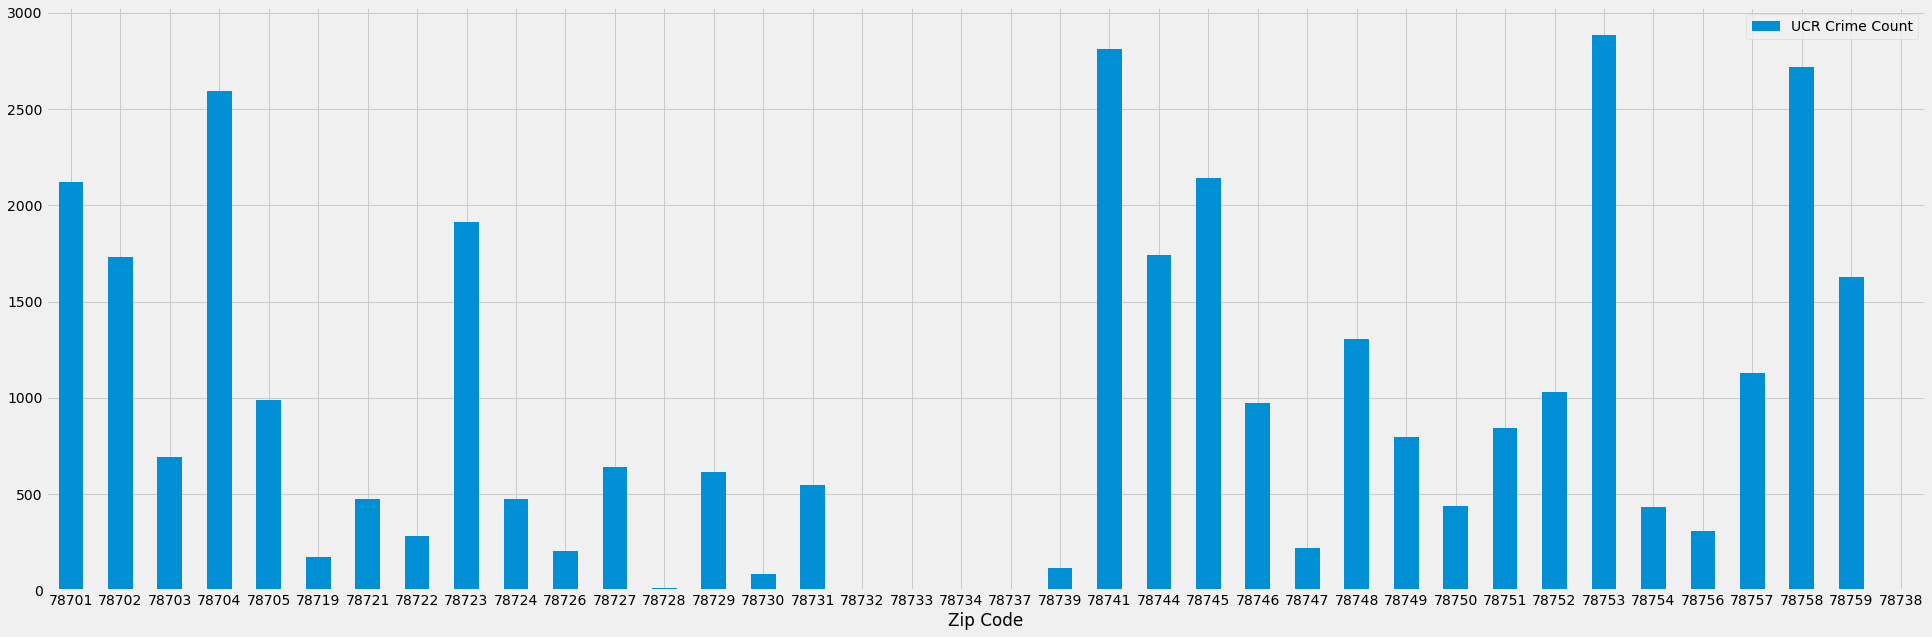

In [82]:
ax = dCrime.plot.bar(x='Zip Code', y='UCR Crime Count', rot=0,figsize=(30,10),sort_columns=True)

## Get Neighborhood Data

### Get Venue Data

#### Set up Foresquare

In [39]:
# Credentials have been removed for security

CLIENT_ID = 'BWAEZICJWE0EEXJ3DCXOPOI0MQH4VK12SPN3TTPAOOMTNKEG' # your Foursquare ID
CLIENT_SECRET = 'GXU2UIO2OJQMQ1P1D210NGFEPJFJYGOXID1OQV1I5PHIUPAH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BWAEZICJWE0EEXJ3DCXOPOI0MQH4VK12SPN3TTPAOOMTNKEG
CLIENT_SECRET:GXU2UIO2OJQMQ1P1D210NGFEPJFJYGOXID1OQV1I5PHIUPAH


#### Borrow Code from previous IBM Lab

In [40]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,maxreturn=100):

    i=1
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
       # print("Processing: ",i," ",name)
        i=i+1
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            maxreturn)
        #print(url)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Get Venues by Zip code

In [41]:
Austin_venues = getNearbyVenues(names=dZip['Zip Code'],
                                   latitudes=dZip['Lat'],
                                   longitudes=dZip['Lng'],
                                   radius=750
                                  )

Lets Get the shape of the area and look at sample data

In [42]:
print(Austin_venues.shape)
Austin_venues.head()

(721, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,78701,30.27049,-97.74235,Perry's Steakhouse,30.269374,-97.743676,Steakhouse
1,78701,30.27049,-97.74235,Upstairs at Caroline,30.268810,-97.742310,Hotel
2,78701,30.27049,-97.74235,Paramount Theatre,30.269457,-97.742077,Movie Theater
3,78701,30.27049,-97.74235,The Townsend,30.269611,-97.742448,Lounge
4,78701,30.27049,-97.74235,CU29 Cocktail Bar,30.269133,-97.741159,Cocktail Bar


Let us look at the type of venues returned

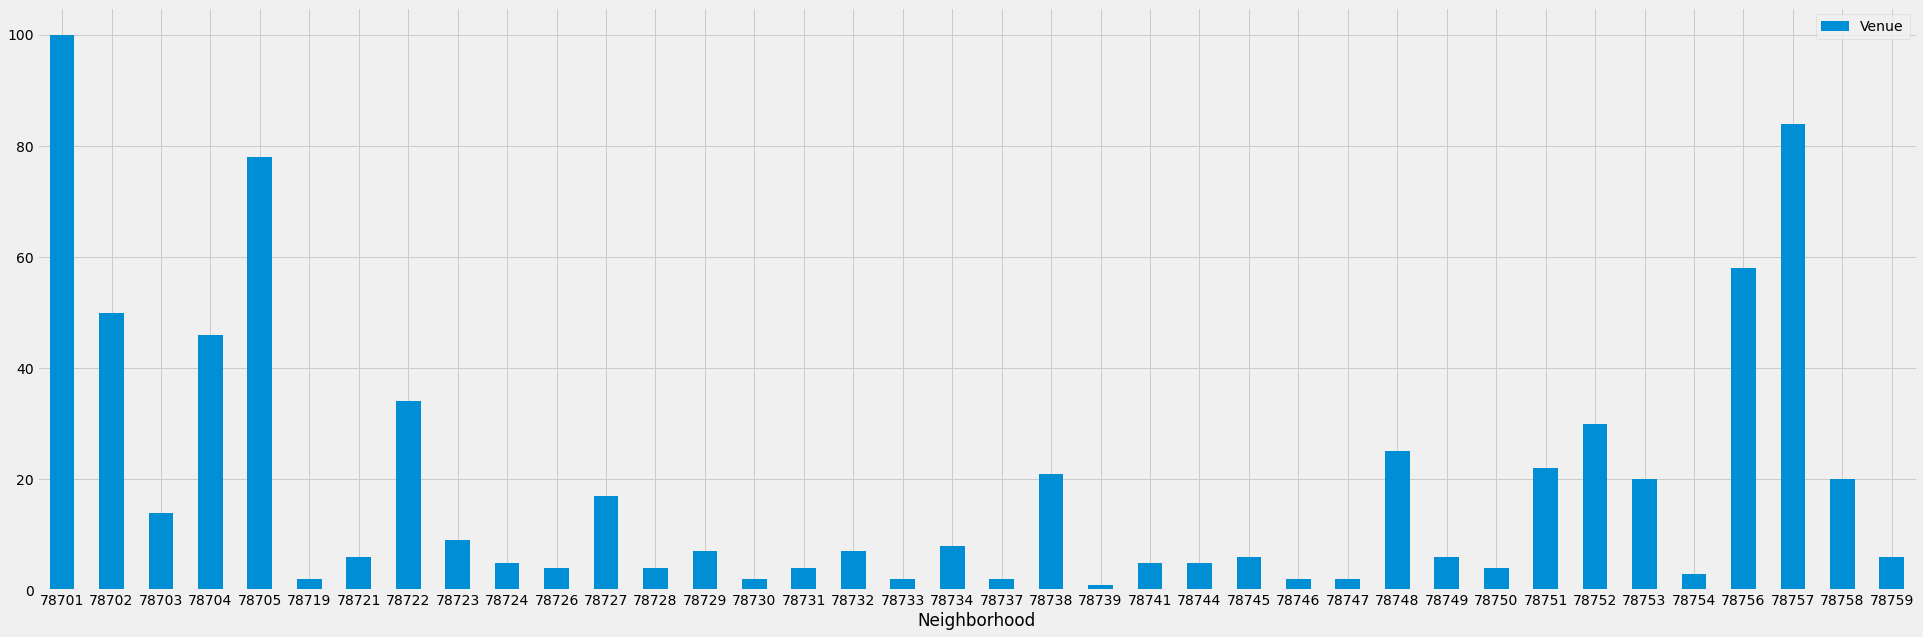

In [83]:
Austin_VenueCount = Austin_venues.groupby('Neighborhood').count().reset_index()
ax = Austin_VenueCount.plot.bar(x='Neighborhood', y='Venue', rot=0,figsize=(30,10),sort_columns=True)

In [44]:
Austin_VenueCount.shape

(38, 7)

In [45]:
print('There are {} uniques categories in Austin.'.format(len(Austin_venues['Venue Category'].unique())))

There are 204 uniques categories in Austin.


## Analyze the Neighborhoods

#### Create One Hot Encoding of Neighborhood data

In [46]:
# one hot encoding
Austin_onehot = pd.get_dummies(Austin_venues['Venue Category'], prefix="", prefix_sep="")

###  Note Aparently there is now a Venue Categor "Neighborhood in FourSque", we will use Zip Code for string
 
Austin_onehot.insert(0, 'Zip Code', Austin_venues['Neighborhood'])
Austin_onehot.head()

,Zip Code,Adult Boutique,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,78701,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,78701,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,78701,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,78701,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,78701,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [47]:
Austin_grouped = Austin_onehot.groupby('Zip Code').mean().reset_index()
Austin_grouped.head()

,Zip Code,Adult Boutique,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,78701,0.0,0.020000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.01,0.02,0.00,0.0,0.010000
1,78702,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.020000,0.0,0.0,...,0.020000,0.0,0.020000,0.0,0.0,0.00,0.00,0.02,0.0,0.000000
2,78703,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.071429,0.0,0.000000,0.0,0.0,0.00,0.00,0.00,0.0,0.142857
3,78704,0.0,0.021739,0.0,0.000000,0.021739,0.0,0.021739,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.00,0.00,0.00,0.0,0.000000
4,78705,0.0,0.000000,0.0,0.012821,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.012821,0.0,0.0,0.00,0.00,0.00,0.0,0.012821


In [48]:
#Let us check the shape of the venue dataframe

Austin_grouped.shape

(38, 205)

In [49]:
#someone is missing; who?
dMissing=dZip[(~dZip['Zip Code'].isin(Austin_grouped['Zip Code']))]
dMissing

,Zip Code,Lat,Lng,City,State ID,State Name,Population,Density
6,78717,30.48988,-97.75371,Austin,TX,Texas,30218,674.4
12,78725,30.23581,-97.60837,Austin,TX,Texas,7886,133.1
22,78735,30.26590,-97.86658,Austin,TX,Texas,17923,303.1
23,78736,30.26110,-97.95944,Austin,TX,Texas,9047,92.5
28,78742,30.24413,-97.65830,Austin,TX,Texas,828,54.9


Five low Density areas which returns no venues, one an industrial estate another a park.  Lets drop them from our previous tables

In [50]:
#Five low Density areas which returns no venues, one an inductrial estate another a park.  Lets drop them from our previous tables
def DropRowOnColumnValue(Df,ColumnName,ZipList):
    for i in ZipList: 
        Df=Df[Df[ColumnName] != i]
    #Df.reset_index(inplace=True)
    return(Df)

DropList=['78717','78725','78735','78736','78742']


dZip = DropRowOnColumnValue(dZip ,"Zip Code",DropList)
dIncome = DropRowOnColumnValue(dIncome ,"Zip Code",DropList)
dAge = DropRowOnColumnValue(dAge,"Zip Code",DropList)
dAlcSales= DropRowOnColumnValue(dAlcSales ,"Zip Code",DropList)
dCrime= DropRowOnColumnValue(dCrime,"Zip Code",DropList)
print(dZip.shape,dIncome.shape,dAge.shape,dAlcSales.shape,dCrime.shape)
#Austin_grouped=DropRowOnColumnValue(Austin_grouped,"Zip Code",DropList)

(38, 8) (38, 2) (38, 7) (38, 6) (38, 2)


### Lets look at Venues

In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [52]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zip Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Zip Code'] = Austin_grouped['Zip Code']

for ind in np.arange(Austin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Austin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()
neighborhoods_venues_sorted

,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,78701,Hotel,Coffee Shop,Bar,Lounge,Cocktail Bar,Capitol Building,Nightclub,Hotel Bar,Seafood Restaurant,Speakeasy
1,78702,Coffee Shop,Pub,Mexican Restaurant,Fast Food Restaurant,Bar,Convenience Store,Park,Cocktail Bar,Pizza Place,Food Truck
2,78703,Yoga Studio,Spa,Park,Tanning Salon,Shoe Store,Dry Cleaner,Trail,Vegetarian / Vegan Restaurant,Sports Club,Health Food Store
3,78704,Food Truck,Mexican Restaurant,Thai Restaurant,Park,Coffee Shop,Gym / Fitness Center,Event Service,Comfort Food Restaurant,Pharmacy,Cosmetics Shop
4,78705,Food Truck,Burger Joint,Sandwich Place,Coffee Shop,Taco Place,Thai Restaurant,Mexican Restaurant,Thrift / Vintage Store,Pub,Pizza Place
5,78719,Arts & Entertainment,Auto Workshop,Yoga Studio,Dog Run,Food,Flower Shop,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market
6,78721,Park,Art Gallery,Night Market,Dessert Shop,Playground,Cycle Studio,Dog Run,Field,Fast Food Restaurant,Farmers Market
7,78722,Taco Place,Intersection,Bar,Sandwich Place,Theater,Gas Station,Convenience Store,Cupcake Shop,Mexican Restaurant,Gastropub
8,78723,Food Truck,Grocery Store,Disc Golf,Donut Shop,Convenience Store,Mobile Phone Shop,Gas Station,Cosmetics Shop,Ice Cream Shop,Health & Beauty Service
9,78724,General Entertainment,Other Great Outdoors,Lounge,Athletics & Sports,Yoga Studio,Dog Run,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market


## Creation of a Scoring Matrix

We have identified what we believe are the desirabele features of our new Irish Pub loaction: Population Density, a Young Adult Population Age, High revenues from the sale of Alcohol, and Low Crime.
We will score these factors for each Austin zip code identified by adding the normalice values for each category.  We will then rank each zip code on a category basis and award a final overall ranking. 

### Merge the desired location features

In [53]:
concatenated=pd.merge(dZip[['Zip Code','Density']], dIncome[['Zip Code','Avg. Income/H/hold']], how='inner', on='Zip Code')
concatenated = pd.merge(concatenated, dAge[['Zip Code','Avg. Population Age']], how="inner", on='Zip Code')
concatenated = pd.merge(concatenated, dAlcSales[['Zip Code','Total Receipts']], how="inner", on='Zip Code')
concatenated = pd.merge(concatenated, dCrime, how="inner", on='Zip Code')
concatenated.head() 

,Zip Code,Density,Avg. Income/H/hold,Avg. Population Age,Total Receipts,UCR Crime Count
0,78701,1621.8,35757.0,36.1,2938494875,2119
1,78702,1648.1,23348.0,29.8,331019849,1730
2,78703,1366.4,54591.0,34.5,224481722,691
3,78704,1871.5,35733.0,30.6,929197089,2593
4,78705,5511.2,14740.0,21.2,148663399,988


In [54]:
dFeaturesNormalized=concatenated.drop(['Zip Code'], axis = 1) 
from sklearn import preprocessing

x = dFeaturesNormalized.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dScore = pd.DataFrame(x_scaled, index=dFeaturesNormalized.index, columns=dFeaturesNormalized.columns)
dScore.head()


,Density,Avg. Income/H/hold,Avg. Population Age,Total Receipts,UCR Crime Count
0,0.289555,0.184710,0.634043,1.000000,0.734489
1,0.294359,0.075652,0.365957,0.112596,0.599653
2,0.242904,0.350234,0.565957,0.076337,0.239515
3,0.335166,0.184499,0.400000,0.316174,0.898787
4,1.000000,0.000000,0.000000,0.050534,0.342461


In [55]:
# we want the inverse of the crime data (lower crime ranks higher), same for Median age
dFeaturesNormalized["UCR Crime Count"]=1-dScore["UCR Crime Count"]
dScore["Avg. Population Age"]=1-dScore["Avg. Population Age"]
# finally we add all columns, eccept zip, to get a score
dScore["Score"]=dScore.sum(axis=1)
# Lets Put the Zip code Back
dScore.insert(0, 'Zip Code', concatenated['Zip Code'])
dScore.head()

,Zip Code,Density,Avg. Income/H/hold,Avg. Population Age,Total Receipts,UCR Crime Count,Score
0,78701,0.289555,0.184710,0.365957,1.000000,0.734489,2.574711
1,78702,0.294359,0.075652,0.634043,0.112596,0.599653,1.716303
2,78703,0.242904,0.350234,0.434043,0.076337,0.239515,1.343032
3,78704,0.335166,0.184499,0.600000,0.316174,0.898787,2.334625
4,78705,1.000000,0.000000,1.000000,0.050534,0.342461,2.392995


The Normalized values are difficult to read.  Let us create a new dataframe that shows the ranking for each desired feture and the final score

Create an intuitice  Ranking Matrix <b>dRankings</b>

In [56]:
dRankings = pd.DataFrame()
dRankings.insert(0,'Zip Code',dScore["Zip Code"]) 
dRankings.insert(1, 'Density Rank',concatenated['Density'].rank(ascending=False).astype(int))
dRankings.insert(2, 'Income Rank',concatenated['Avg. Income/H/hold'].rank(ascending=False).astype(int))
dRankings.insert(3, 'Youth Rank',concatenated['Avg. Population Age'].rank(ascending=False).astype(int))
dRankings.insert(4, 'Alcohol Sales Rank',concatenated['Total Receipts'].rank(ascending=False).astype(int))
dRankings.insert(4, 'Safety Rank',concatenated['UCR Crime Count'].rank(ascending=False).astype(int))
dRankings.insert(6,'Score Rank',dScore['Score'].rank(ascending=False).astype(int))
dRankings.sort_values(by=['Score Rank'],inplace=True,ignore_index=True)

#Let us look at our Scores
dRankings.head()

,Zip Code,Density Rank,Income Rank,Youth Rank,Safety Rank,Alcohol Sales Rank,Score Rank
0,78701,11,30,9,6,1,1
1,78741,3,36,37,2,13,2
2,78705,1,38,38,14,10,3
3,78758,6,23,28,3,3,4
4,78704,5,31,25,4,2,5


## Run K-Means on Neighborhood venue data

In [57]:
Austin_grouped.head()

,Zip Code,Adult Boutique,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,78701,0.0,0.020000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.01,0.02,0.00,0.0,0.010000
1,78702,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.020000,0.0,0.0,...,0.020000,0.0,0.020000,0.0,0.0,0.00,0.00,0.02,0.0,0.000000
2,78703,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.071429,0.0,0.000000,0.0,0.0,0.00,0.00,0.00,0.0,0.142857
3,78704,0.0,0.021739,0.0,0.000000,0.021739,0.0,0.021739,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.00,0.00,0.00,0.0,0.000000
4,78705,0.0,0.000000,0.0,0.012821,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.012821,0.0,0.0,0.00,0.00,0.00,0.0,0.012821


In [58]:
#We copy the dataframe, just as a recovery point so that we don't have to rerun the whole notebook to tweak K-Means
dKMeans=Austin_grouped.copy(deep=True)
dKMeans.head()

,Zip Code,Adult Boutique,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,78701,0.0,0.020000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.01,0.02,0.00,0.0,0.010000
1,78702,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.020000,0.0,0.0,...,0.020000,0.0,0.020000,0.0,0.0,0.00,0.00,0.02,0.0,0.000000
2,78703,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.071429,0.0,0.000000,0.0,0.0,0.00,0.00,0.00,0.0,0.142857
3,78704,0.0,0.021739,0.0,0.000000,0.021739,0.0,0.021739,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.00,0.00,0.00,0.0,0.000000
4,78705,0.0,0.000000,0.0,0.012821,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.012821,0.0,0.0,0.00,0.00,0.00,0.0,0.012821


In [59]:
Austin_Grouped_ClusterLabel=Austin_grouped.copy(deep=True)
print(dKMeans.shape,Austin_Grouped_ClusterLabel.shape)

(38, 205) (38, 205)


In [60]:
dKMeans.drop('Zip Code', axis=1, inplace=True)
import pandas as pd
from sklearn import preprocessing

x = dKMeans.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dKMeans = pd.DataFrame(x_scaled)
print(dKMeans.shape,Austin_Grouped_ClusterLabel.shape)
dKMeans.head()


(38, 204) (38, 205)


,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,200,201,202,203
0,0.0,0.600000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.070000
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.92,0.0,0.0,0.0,...,0.28,0.0,0.120000,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,...,1.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
3,0.0,0.652174,0.0,0.0,0.130435,0.0,1.00,0.0,0.0,0.0,...,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.000000,0.0,1.0,0.000000,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.089744


In [61]:
import matplotlib.pyplot as plt  
from matplotlib import style 
from sklearn.cluster import KMeans 

#Austin_grouped_clustering =Austin_grouped.drop('NBH', 1)

cost=[] 
numCluster=30
for i in range(1, numCluster):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit((dKMeans))
    cost.append(KM.inertia_)      
  

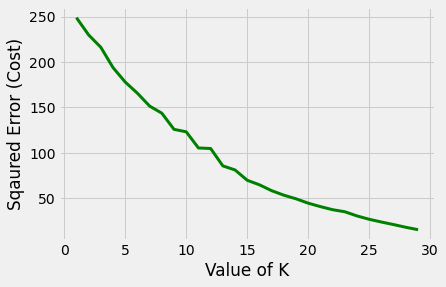

In [62]:
# plot the cost against K values 
plt.style.use("fivethirtyeight")
plt.plot(range(1, numCluster), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)")
plt.show() # clear the plot 
# the point of the elbow is the most optimal value for choosing k 

In [63]:
from kneed import KneeLocator
kl = KneeLocator(range(1, numCluster), cost, curve="convex", direction="decreasing")
kl.elbow

15

In [64]:
print(dKMeans.shape,Austin_Grouped_ClusterLabel.shape)
# set number of clusters
kclusters =kl.elbow

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Austin_Grouped_ClusterLabel)

#Add clustering labels to dataframe ( Austin_Grouped_ClusterLabel )
Austin_Grouped_ClusterLabel.insert(1, 'Cluster Labels', kmeans.labels_)
Austin_Grouped_ClusterLabel.head()

(38, 204) (38, 205)


,Zip Code,Cluster Labels,Adult Boutique,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,78701,8,0.0,0.020000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.01,0.02,0.00,0.0,0.010000
1,78702,8,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.020000,0.0,...,0.020000,0.0,0.020000,0.0,0.0,0.00,0.00,0.02,0.0,0.000000
2,78703,8,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.071429,0.0,0.000000,0.0,0.0,0.00,0.00,0.00,0.0,0.142857
3,78704,0,0.0,0.021739,0.0,0.000000,0.021739,0.0,0.021739,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.00,0.00,0.00,0.0,0.000000
4,78705,0,0.0,0.000000,0.0,0.012821,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.012821,0.0,0.0,0.00,0.00,0.00,0.0,0.012821


In [65]:
dMerge = pd.merge(left=dZip,right=Austin_Grouped_ClusterLabel, left_on='Zip Code', right_on='Zip Code')
print(dMerge.shape)
dMerge.head()

(38, 213)


,Zip Code,Lat,Lng,City,State ID,State Name,Population,Density,Cluster Labels,Adult Boutique,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,78701,30.27049,-97.74235,Austin,TX,Texas,9427,1621.8,8,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.01,0.02,0.00,0.0,0.010000
1,78702,30.26327,-97.71432,Austin,TX,Texas,23389,1648.1,8,0.0,...,0.020000,0.0,0.020000,0.0,0.0,0.00,0.00,0.02,0.0,0.000000
2,78703,30.29409,-97.76571,Austin,TX,Texas,20890,1366.4,8,0.0,...,0.071429,0.0,0.000000,0.0,0.0,0.00,0.00,0.00,0.0,0.142857
3,78704,30.24315,-97.76537,Austin,TX,Texas,48486,1871.5,0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.00,0.00,0.00,0.0,0.000000
4,78705,30.29437,-97.73855,Austin,TX,Texas,33948,5511.2,0,0.0,...,0.000000,0.0,0.012821,0.0,0.0,0.00,0.00,0.00,0.0,0.012821


### Plot the resulting clusters

In [66]:
#Create Folium Map
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

#Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dMerge['Lat'], dMerge['Lng'], dMerge['Zip Code'], dMerge['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

Examine each cluster and determine the discriminating venue categories that distinguish the cluster.

In [67]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Austin_merged = dZip

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Austin_merged = Austin_merged.join(neighborhoods_venues_sorted.set_index('Zip Code'), on='Zip Code')

Austin_merged .head() # check the last columns!

,Zip Code,Lat,Lng,City,State ID,State Name,Population,Density,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,78701,30.27049,-97.74235,Austin,TX,Texas,9427,1621.8,8,Hotel,Coffee Shop,Bar,Lounge,Cocktail Bar,Capitol Building,Nightclub,Hotel Bar,Seafood Restaurant,Speakeasy
1,78702,30.26327,-97.71432,Austin,TX,Texas,23389,1648.1,8,Coffee Shop,Pub,Mexican Restaurant,Fast Food Restaurant,Bar,Convenience Store,Park,Cocktail Bar,Pizza Place,Food Truck
2,78703,30.29409,-97.76571,Austin,TX,Texas,20890,1366.4,8,Yoga Studio,Spa,Park,Tanning Salon,Shoe Store,Dry Cleaner,Trail,Vegetarian / Vegan Restaurant,Sports Club,Health Food Store
3,78704,30.24315,-97.76537,Austin,TX,Texas,48486,1871.5,0,Food Truck,Mexican Restaurant,Thai Restaurant,Park,Coffee Shop,Gym / Fitness Center,Event Service,Comfort Food Restaurant,Pharmacy,Cosmetics Shop
4,78705,30.29437,-97.73855,Austin,TX,Texas,33948,5511.2,0,Food Truck,Burger Joint,Sandwich Place,Coffee Shop,Taco Place,Thai Restaurant,Mexican Restaurant,Thrift / Vintage Store,Pub,Pizza Place


In [68]:
for i in range(0, kclusters):
    print("Cluster ",i)
    dTmp=Austin_merged.loc[Austin_merged['Cluster Labels'] == i, Austin_merged.columns[[0] + list(range(9, Austin_merged.shape[1]))]]
    display(dTmp)


Cluster  0


,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,78704,Food Truck,Mexican Restaurant,Thai Restaurant,Park,Coffee Shop,Gym / Fitness Center,Event Service,Comfort Food Restaurant,Pharmacy,Cosmetics Shop
4,78705,Food Truck,Burger Joint,Sandwich Place,Coffee Shop,Taco Place,Thai Restaurant,Mexican Restaurant,Thrift / Vintage Store,Pub,Pizza Place


Cluster  1


,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,78747,IT Services,Construction & Landscaping,American Restaurant,Dog Run,Food,Flower Shop,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market
33,78748,Food Truck,Gym,Restaurant,Sandwich Place,Breakfast Spot,Optical Shop,Liquor Store,Furniture / Home Store,Clothing Store,Bakery
34,78749,Park,Assisted Living,Business Service,Doctor's Office,Pool,Dance Studio,Deli / Bodega,Financial or Legal Service,Field,Fast Food Restaurant


Cluster  2


,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,78726,Restaurant,Mattress Store,Gym,Donut Shop,Yoga Studio,Doctor's Office,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market
14,78727,Mediterranean Restaurant,Thai Restaurant,Pharmacy,Pizza Place,Coffee Shop,Dry Cleaner,Financial or Legal Service,Middle Eastern Restaurant,Cosmetics Shop,Food Truck
15,78728,Bookstore,Furniture / Home Store,Café,Gym,Yoga Studio,Dog Run,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market


Cluster  3


,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,78756,Yoga Studio,Bakery,Sandwich Place,Coffee Shop,Mexican Restaurant,Thrift / Vintage Store,Taco Place,Gas Station,Food Truck,Pizza Place
41,78757,Furniture / Home Store,Sandwich Place,Mobile Phone Shop,Bakery,Salon / Barbershop,Donut Shop,Comic Shop,Mexican Restaurant,Burger Joint,Taco Place


Cluster  4


,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,78732,Playground,Trail,Music Store,Park,Pool,Cycle Studio,Dance Studio,Field,Fast Food Restaurant,Farmers Market
20,78733,Business Service,Disc Golf,Yoga Studio,Dog Run,Flower Shop,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant
21,78734,Food,Soccer Field,Mexican Restaurant,Ski Shop,Gym / Fitness Center,Gym,Bakery,Yoga Studio,Doctor's Office,Fast Food Restaurant


Cluster  5


,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,78719,Arts & Entertainment,Auto Workshop,Yoga Studio,Dog Run,Food,Flower Shop,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market


Cluster  6


,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,78739,Trail,Yoga Studio,Doctor's Office,Flower Shop,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Service
27,78741,Bus Station,Residential Building (Apartment / Condo),New American Restaurant,Convenience Store,Yoga Studio,Dog Run,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market


Cluster  7


,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,78721,Park,Art Gallery,Night Market,Dessert Shop,Playground,Cycle Studio,Dog Run,Field,Fast Food Restaurant,Farmers Market
9,78722,Taco Place,Intersection,Bar,Sandwich Place,Theater,Gas Station,Convenience Store,Cupcake Shop,Mexican Restaurant,Gastropub
10,78723,Food Truck,Grocery Store,Disc Golf,Donut Shop,Convenience Store,Mobile Phone Shop,Gas Station,Cosmetics Shop,Ice Cream Shop,Health & Beauty Service
11,78724,General Entertainment,Other Great Outdoors,Lounge,Athletics & Sports,Yoga Studio,Dog Run,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market


Cluster  8


,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,78701,Hotel,Coffee Shop,Bar,Lounge,Cocktail Bar,Capitol Building,Nightclub,Hotel Bar,Seafood Restaurant,Speakeasy
1,78702,Coffee Shop,Pub,Mexican Restaurant,Fast Food Restaurant,Bar,Convenience Store,Park,Cocktail Bar,Pizza Place,Food Truck
2,78703,Yoga Studio,Spa,Park,Tanning Salon,Shoe Store,Dry Cleaner,Trail,Vegetarian / Vegan Restaurant,Sports Club,Health Food Store


Cluster  9


,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,78750,Photography Studio,Furniture / Home Store,Trail,Athletics & Sports,Yoga Studio,Doctor's Office,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market
36,78751,Park,Coffee Shop,Bus Stop,Food Truck,Beer Store,Donut Shop,Taco Place,Sporting Goods Shop,Bus Station,Breakfast Spot
37,78752,Hotel,Mexican Restaurant,Breakfast Spot,Kitchen Supply Store,Movie Theater,Shipping Store,Seafood Restaurant,Sporting Goods Shop,Food Truck,Sushi Restaurant


Cluster  10


,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,78744,Golf Course,Campground,Trail,Park,Dive Bar,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant
30,78745,Food Truck,Construction & Landscaping,Music Store,Video Store,Health & Beauty Service,Yoga Studio,Doctor's Office,Field,Fast Food Restaurant,Farmers Market
31,78746,Boutique,Trail,Doctor's Office,Flower Shop,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Service


Cluster  11


,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,78729,Gym,Playground,Food Truck,Coffee Shop,Cafeteria,Doctor's Office,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant
17,78730,Bar,Scenic Lookout,Yoga Studio,Doctor's Office,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Service
18,78731,Convenience Store,Mexican Restaurant,Gas Station,Assisted Living,Yoga Studio,Dog Run,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market


Cluster  12


,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,78758,Brewery,Yoga Studio,Sushi Restaurant,Massage Studio,Shipping Store,Furniture / Home Store,Donut Shop,Fast Food Restaurant,Sandwich Place,Child Care Service
43,78759,Pool,Basketball Court,Gym,Tennis Court,Golf Course,Scenic Lookout,Dive Bar,Fast Food Restaurant,Farmers Market,Falafel Restaurant


Cluster  13


,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
38,78753,Mexican Restaurant,Gas Station,Rental Car Location,Sandwich Place,Convenience Store,Auto Workshop,Burger Joint,Cosmetics Shop,Fast Food Restaurant,Bank
39,78754,Playground,Gym,Pool,Cosmetics Shop,Doctor's Office,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant


Cluster  14


,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,78737,Stables,Business Service,Construction & Landscaping,Flower Shop,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Service
25,78738,Salon / Barbershop,Pizza Place,Big Box Store,Park,Dog Run,Nail Salon,Fast Food Restaurant,Food,Mexican Restaurant,Mattress Store


### So Where is the Ideal Locaton?

In [69]:
Austin_merged =pd.merge(Austin_merged , dRankings[['Zip Code','Score Rank']], how="inner", on='Zip Code')
Austin_merged.sort_values(by=['Score Rank'],inplace=True,ignore_index=True)
Austin_merged  

,Zip Code,Lat,Lng,City,State ID,State Name,Population,Density,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Score Rank
0,78701,30.27049,-97.74235,Austin,TX,Texas,9427,1621.8,8,Hotel,Coffee Shop,Bar,Lounge,Cocktail Bar,Capitol Building,Nightclub,Hotel Bar,Seafood Restaurant,Speakeasy,1
1,78741,30.23049,-97.71401,Austin,TX,Texas,52716,2285.4,6,Bus Station,Residential Building (Apartment / Condo),New American Restaurant,Convenience Store,Yoga Studio,Dog Run,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market,2
2,78705,30.29437,-97.73855,Austin,TX,Texas,33948,5511.2,0,Food Truck,Burger Joint,Sandwich Place,Coffee Shop,Taco Place,Thai Restaurant,Mexican Restaurant,Thrift / Vintage Store,Pub,Pizza Place,3
3,78758,30.38799,-97.70684,Austin,TX,Texas,47470,1832.3,12,Brewery,Yoga Studio,Sushi Restaurant,Massage Studio,Shipping Store,Furniture / Home Store,Donut Shop,Fast Food Restaurant,Sandwich Place,Child Care Service,4
4,78704,30.24315,-97.76537,Austin,TX,Texas,48486,1871.5,0,Food Truck,Mexican Restaurant,Thai Restaurant,Park,Coffee Shop,Gym / Fitness Center,Event Service,Comfort Food Restaurant,Pharmacy,Cosmetics Shop,5
5,78753,30.38204,-97.67361,Austin,TX,Texas,59085,1751.3,13,Mexican Restaurant,Gas Station,Rental Car Location,Sandwich Place,Convenience Store,Auto Workshop,Burger Joint,Cosmetics Shop,Fast Food Restaurant,Bank,6
6,78745,30.20685,-97.79738,Austin,TX,Texas,62771,1607.4,10,Food Truck,Construction & Landscaping,Music Store,Video Store,Health & Beauty Service,Yoga Studio,Doctor's Office,Field,Fast Food Restaurant,Farmers Market,7
7,78723,30.30427,-97.68570,Austin,TX,Texas,34569,1575.7,7,Food Truck,Grocery Store,Disc Golf,Donut Shop,Convenience Store,Mobile Phone Shop,Gas Station,Cosmetics Shop,Ice Cream Shop,Health & Beauty Service,8
8,78744,30.18277,-97.72920,Austin,TX,Texas,48969,771.6,10,Golf Course,Campground,Trail,Park,Dive Bar,Financial or Legal Service,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,9
9,78759,30.40268,-97.76105,Austin,TX,Texas,42524,1079.0,12,Pool,Basketball Court,Gym,Tennis Court,Golf Course,Scenic Lookout,Dive Bar,Fast Food Restaurant,Farmers Market,Falafel Restaurant,10


So the "winner" based on the score matrix is zip code 78701, the Congress Ave District|Downtown.  This is not surprising as 78701 ranked first in Alcohol sales and was near the top ten concerning safety and youth.  More interesting, and surprising is 78741, the Pleasant Valley neighborhood.  This neighborhood came in higher in density and safety rank with an added bonus that per the venue information, there is not a lot of competition (there are no bars in the top ten) and (one would assume). it appears well served by mass transit with a Bus Station, and price per square foot of retail space would be cheaper; a point of further investigation.  However, 78741 would be my bet, it may be ranked #2, but it tries harder!

## Conclusion

While a theoretical/hypothetical exercise; I believe it makes a strong case for the value of Data Science methods.  Left to their own subjective opinions ands biases, a perspective business owner, in this example an Irish Pub, would be inclined to weigh the obvious, opening a venue in the center of town with high retail operating costs and extensive competition. WHile Data Science did confirm that intuition in returning 78701 as the highest rank, it provides a compelling argument for "a sleeper" in putting forth 78741 which seems to offer tremendous untapped potential and very likely a lower operating cost given it is not in the city center.